In [1]:
import os
import numpy as np
import random
import string
from matplotlib import pyplot as plt
import matplotlib

In [2]:
import cv2

In [3]:
def gradient_vertical(height,width,color1,color2,gamma=2):
    # print(height,width)
    arr = np.tile(np.expand_dims(np.arange(height),axis=(1,2)),(1,width,3))
    col1_im = color1*np.ones((height,width,3))
    col2_im = color2*np.ones((height,width,3))
    
    col1_im = (col1_im)**(1/gamma)
    col2_im = (col2_im)**(1/gamma)
    
    arr = (arr*col1_im + (height-arr)*col2_im)/(height)
    arr = arr**gamma
    
    arr = arr.astype(np.uint8)
    
    return arr


In [4]:
def make_timeline(past):
    vals = np.array(past)
    vals[:, 2] = 1

    # print(np.vstack([[vals[0]], vals[np.sum(vals != vals[0], axis=1).astype(bool)]]))

    vals = np.vstack([[vals[0]], vals[np.sum(vals != vals[0], axis=1).astype(bool)]])

    # print(vals)

    x = vals[:, 0]
    y = vals[:, 1]
    z = vals[:, 2]

    first_x = 0
    end_x = min(int(x.shape[0]/5)+1,x.shape[0]-1)

    line_rot = np.arctan((y[end_x]-y[first_x]) /
                         (x[end_x]-x[first_x]+1e-9)) * 180/np.pi


    if x[end_x]-x[first_x] < 0:
        line_rot += 180
    elif x[end_x] == x[first_x] and y[first_x]-y[end_x] < 0:
        line_rot += 180

    rot = matplotlib.transforms.Affine2D().rotate_deg(90-line_rot)

    fig = plt.figure()

    points = vals[:, :3]
    points[:, 2] = 1

    temp_out = rot.transform(points[:, :2])

    x = -temp_out[:, 0]
    y = temp_out[:, 1]

    plt.plot(x, y, color='black')

    y_min = np.min([y[0]-20, np.min(y)-10])
    y_max = np.max([y[0]+80, np.max(y)+10])

    x_size = np.max([50, np.max(x)-x[0]+10, x[0]-np.min(x)+10])
    x_min = x[0]-x_size
    x_max = x[0]+x_size

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.gca().set_aspect('equal')
    plt.axis('off')

    fig.canvas.draw()
    timeline = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    timeline = timeline.reshape(fig.canvas.get_width_height()[::-1]+(3,))
    plt.close()
    timeline = timeline[:, :, 0].astype(np.float32)/255
    timeline = 1-timeline
    return timeline

In [5]:
def world_to_pixel(K, rgb_matrix, destination,  curr_position):

    point_3d = np.ones((4, destination.shape[1]))
    point_3d[0] = destination[0]
    point_3d[1] = destination[1]
    point_3d[2] = destination[2]

    # point_3d = np.array([destination[0], destination[1], curr_position[2], 1])
    point_3d = np.round(point_3d, decimals=2)
    # print("3D world coordinate: ", point_3d)

    cam_coords = rgb_matrix @ point_3d
    # cam_coords = rgb_matrix @ point_3d[:, None]
    cam_coords = np.array([cam_coords[1], cam_coords[2]*-1, cam_coords[0]])

    cam_coords = cam_coords[:, cam_coords[2, :] > 0]
    points_2d = np.dot(K, cam_coords)

    points_2d = np.array([
        points_2d[0, :] / points_2d[2, :],
        points_2d[1, :] / points_2d[2, :],
        points_2d[2, :]]
    )
    points_2d = points_2d.reshape(3, -1)
    points_2d = np.round(points_2d, decimals=2)
    return points_2d


In [12]:
def gen_mask(K,inverse_matrix,target_coordinate,float_coordinate,size):
    w,h = size
    im = np.zeros((size[1],size[0],3)).astype(np.uint8)

    x_offsets = np.linspace(-2.5, 2.5, num=150)
    y_offsets = np.linspace(-2.5, 2.5, num=150)
    X, Y = np.meshgrid(x_offsets, y_offsets)


    mesh_mask = np.where((X**2+Y**2>5.29)&(X**2+Y**2<=6.25))

    mesh = np.dstack([X[mesh_mask], Y[mesh_mask]])

    mesh = mesh.reshape(-1, 2)

    mesh = np.hstack([mesh, np.zeros((mesh.shape[0], 1))]).T

    annotations = world_to_pixel(
        K, inverse_matrix, target_coordinate.reshape(3, 1)+mesh, float_coordinate).T

    for i in range(annotations.shape[0]):
        x = round(annotations[i, 0])
        y = round(annotations[i, 1])
        if x < 0 or x >= w or y < 0 or y >= h:
            continue
        # import pdb; pdb.set_trace()
        im = cv2.circle(im, (int(x), int(y)), 2,
                        (0xF0,0xC2,0x26), thickness=-1)

    mesh_mask = np.where(X**2+Y**2<=0.81)

    mesh = np.dstack([X[mesh_mask], Y[mesh_mask]])

    mesh = mesh.reshape(-1, 2)

    mesh = np.hstack([mesh, ((0.81-mesh[:,0]**2-mesh[:,1]**2)/0.81)[:,np.newaxis]*0.15]).T

    annotations = world_to_pixel(
        K, inverse_matrix, target_coordinate.reshape(3, 1)+mesh, float_coordinate).T

    x_min = 1e9-1
    x_max = 0
    y_max = 0
    y_min = 1e9-1

    for i in range(annotations.shape[0]):
        x = round(annotations[i, 0])
        y = round(annotations[i, 1])
        
        y_max = max(y_max,y)
        y_min = max(min(y_min,y),0)
        x_max = min(max(x_max,x),w-1)
        x_min = max(min(x_min,x),0)

        if x < 0 or x >= w or y < 0 or y >= h:
            continue
        # import pdb; pdb.set_trace()
        im = cv2.circle(im, (int(x), int(y)), 3,
                        (0xFF,0x83,0x56), thickness=-1)
    
    rep_mask = np.where(np.sum(im,axis=2)>0)

    if rep_mask[0].size==0:
        return rep_mask,im

    y_max = min(int((y_min+y_max)/2),h-1)
    
    if y_max<y_min:
        y_min = y_max
    if x_max < x_min:
        x_min = x_max
    
    
    grad_width = int(x_max-x_min)
    grad_height = int(grad_width*5)
    y_min = int(y_max-grad_height)
    y_max = int(y_max)
    x_min = int(x_min)
    x_max = int(x_max)

    # print(x_max,x_min)
    # print(y_max,y_min)
    
    if grad_width<=0 or grad_height <= 0:
        return rep_mask,im

    gradient = gradient_vertical(grad_height,grad_width,
                np.array([0x1C,0xEB,0xA9]),np.array([0,0,0]),4.5)

    im = im.astype(np.float32)

    grad_im = np.zeros((size[1],size[0],3)).astype(np.float32)

    grad_im[max(y_min,0):y_max,x_min:x_max] = grad_im[max(y_min,0):y_max,x_min:x_max] + gradient[-min(y_min,0):,:]

    grad_im[im>255]=255

    grad_im = grad_im.astype(np.uint8)

    grad_im[rep_mask] = im[rep_mask]


    return rep_mask,grad_im

In [7]:
def to_video(images_folder,annotations_folder,positions_file,video_file,fps=30):
    try:
        frames = sorted(os.listdir(images_folder))
    except Exception as e:
        print(e)
        return
    
    if len(frames)==0:
        return

    past = np.loadtxt(positions_file,delimiter=',').tolist()
    
    frame_count = 0
    im = cv2.imread(os.path.join(images_folder,frames[0]))
    size = (im.shape[1],im.shape[0])

    kernel = np.ones((10, 10), np.uint8)

    idx = 0

    h_offset = 10
    v_offset = 10
    context_size = (320,240)


    try:
        result = cv2.VideoWriter(video_file,cv2.VideoWriter_fourcc(*'MJPG'),fps,size)
        for frame_count, frame in enumerate(frames):
            print('\r'+os.path.join(images_folder,frame),end='')
            
            im = cv2.imread(os.path.join(images_folder,frame))
            im = cv2.resize(im,size)
            mask = cv2.imread(os.path.join(annotations_folder,frame))
            mask = cv2.cvtColor(cv2.resize(mask,size),cv2.COLOR_BGR2GRAY)
            
            # context = cv2.imread(os.path.join(context_folder,frame))
            # context = cv2.dilate(context, kernel, iterations=1)

            context = make_timeline(past[:idx+1])*255
            context = cv2.cvtColor(cv2.resize(context,context_size),cv2.COLOR_GRAY2RGB)
            # plt.imshow(context,cmap='gray')
            # plt.show()

            im[mask>0,:] = 0
            im[mask>0,1] = 255

            im[v_offset:v_offset+context.shape[0],h_offset:h_offset+context.shape[1],:] = context
            
            
            if frame_count == 0:
                plt.imshow(cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
                plt.show()
            result.write(im)
            
            cv2.imshow('frames', im)

            idx += 1

            # break
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except Exception as e:
        print(e)
        raise(e)
    finally:
        result.release()
        cv2.destroyAllWindows()

In [36]:
def to_video_nomask(images_folder,inverse_mat_folder,target_file,positions_file,intrinsic_file,video_file,fps=30):
    try:
        frames = sorted(os.listdir(images_folder))
    except Exception as e:
        print(e)
        return
    
    if len(frames)==0:
        return

    past = np.loadtxt(positions_file,delimiter=',').tolist()
    target_coordinates = np.loadtxt(target_file,delimiter=',')[:,:3]
    float_coordinates = np.array(past)

    K = np.load(intrinsic_file)


    
    frame_count = 0
    im = cv2.imread(os.path.join(images_folder,frames[0]))
    size = (im.shape[1],im.shape[0])

    kernel = np.ones((10, 10), np.uint8)

    idx = 0

    h_offset = 10
    v_offset = 10
    context_size = (320,240)


    try:
        result = cv2.VideoWriter(video_file,cv2.VideoWriter_fourcc(*'MJPG'),fps,size)
        for frame_count, frame in enumerate(frames):
            print('\r'+os.path.join(images_folder,frame),end='')
            
            im = cv2.imread(os.path.join(images_folder,frame))
            im = cv2.resize(im,size)

            inverse_matrix = np.load(os.path.join(inverse_mat_folder,  '.'.join(frame.split('.')[:-1])+'.npy'))

            rep_mask, mask = gen_mask(K,inverse_matrix,target_coordinates[idx],float_coordinates[idx],size)

            context = make_timeline(past[:idx+1])*255
            context = cv2.cvtColor(cv2.resize(context,context_size),cv2.COLOR_GRAY2RGB)

            im = im.astype(np.float32)
            im = im+mask
            im[rep_mask] = mask[rep_mask]
            im[im>255] = 255
            im = im.astype(np.uint8)

            
            im[v_offset:v_offset+context.shape[0],h_offset:h_offset+context.shape[1],:] = context
            
            
            if frame_count == 0:
                plt.imshow(cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
                plt.show()
            result.write(im)
            
            cv2.imshow('frames', im)

            # if idx == 0:
            #     cv2.imwrite('first_frame.png',im)

            idx += 1

            # break
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except Exception as e:
        print(e)
        raise(e)
    finally:
        result.release()
        cv2.destroyAllWindows()

In [37]:
# base_folder = 'E:/icra video/all/good'
base_folder = '_out'

In [40]:
folders = [ str(x) for x in sorted([ int(x) for x in os.listdir(base_folder)])]


In [27]:
for folder in folders:
    if 'video.mp4' in os.listdir(os.path.join(base_folder,folder)):
        print(f'{folder} already processed')
        continue

    if 'masks' not in os.listdir(os.path.join(base_folder,folder)):
        print(f'{folder} doesn\'t have masks')
        continue

    if len(os.listdir(os.path.join(base_folder,folder,'images'))) != len(os.listdir(os.path.join(base_folder,folder,'masks'))):
        print(f'{folder} incomplete masks')
        continue


    with open(os.path.join(base_folder,folder,'command.txt')) as f:
        lines = f.readlines()
        print(lines)
    to_video(os.path.join(base_folder,folder,'images'),
             os.path.join(base_folder,folder,'masks'),
             os.path.join(base_folder,folder,'vehicle_positions.txt'),
             os.path.join(base_folder,folder,'video.mp4'),
            fps=10)

55 already processed


27 already processed
28 already processed
['turn right and stop next to the bus stop']
E:/icra video/all/good\54\images\00002956.png

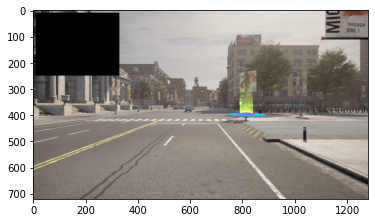

E:/icra video/all/good\54\images\00003957.png55 already processed
56 already processed
57 already processed
58 already processed
60 already processed


In [41]:
for folder in folders:
    if 'video.mp4' in os.listdir(os.path.join(base_folder,folder)):
        print(f'{folder} already processed')
        continue



    with open(os.path.join(base_folder,folder,'command.txt')) as f:
        lines = f.readlines()
        print(lines)
    to_video_nomask(os.path.join(base_folder,folder,'images'),
             os.path.join(base_folder,folder,'inverse_matrix'),
             os.path.join(base_folder,folder,'target_positions.txt'),
             os.path.join(base_folder,folder,'vehicle_positions.txt'),
             os.path.join(base_folder,folder,'camera_intrinsic.npy'),
             os.path.join(base_folder,folder,'video.mp4'),
            fps=10)

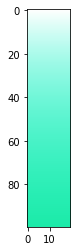

In [122]:
plt.imshow(gradient_vertical(100,20,np.array([0x1C,0xEB,0xA9]),np.array([255,255,255]),7.5))